In [1]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
import random
%matplotlib inline
import scipy.optimize as opt

In [2]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

In [3]:
#fieldfit=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
#pcolormesh(lon,lat,fieldfit[38,:,:])

In [4]:
x,y=linspace(-10,10,50),linspace(-10,10,50)
X,Y=meshgrid(x,y)
gaussian=twoD_Gaussian((X,Y, 1, 0, 0), 2.5, 2.5, 0, 0)
zz=gaussian.reshape(50,50)
#gausssianfitp=fit2Dgaussian(zz,x,y,0.1,initial_guess='',date='',diagnostics=True)

# Flat Background 

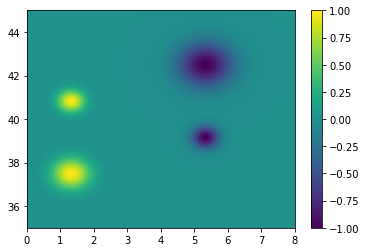

In [5]:
zz=moveGaussian(600,70,array([[x,x*0+150] for x in linspace(100,400,40)]),40)+\
    moveGaussian(600,50,array([[x,x*0+350] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,50,array([[500-x,x*0+250] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,100,array([[500-x,x*0+450] for x in linspace(100,400,40)]),40)
    
lat=linspace(35,45,600)
lon=linspace(0,8,600)
pcolormesh(lon,lat,zz[0,:,:])
colorbar()

In [6]:
eddytdp=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,1,0.1,0.1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,-1,-0.1,-0.1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

 0% [=======================================>]100% Time Elapsed: 68 s  Number of contours analysed: 80 
 0% [=======================================>]100% Time Elapsed: 81 s  Number of contours analysed: 80 


In [7]:
eddytdp.keys()

dict_keys(['eddyn_0', 'eddyn_1'])

In [8]:
#def reconstruct_syntetic(var,eddytd):
#    fieldfit=np.zeros(np.shape(var))
#    for key in eddytd.keys():
#        gaussfit=eddytd[key]['2dgaussianfit'][0]['gaussfit']
#        for ii in range(0,len(eddytd[key]['2dgaussianfit'])):
#            xindexpos=eddytd[key]['2dgaussianfit'][ii]['xindexpos']
#            yindexpos=eddytd[key]['2dgaussianfit'][ii]['yindexpos']
#            eddySfield=eddytd[key]['2dgaussianfit'][ii]['gaussfit']
#            fieldfit[ii,yindexpos[0]:yindexpos[1],xindexpos[0]:xindexpos[1]]=eddySfield
#    return fieldfit


In [9]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
fieldSn=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
fieldS=fieldSp+fieldSn

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zz[ii,:,:],axis=1),sum(fieldS[ii,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(fieldS[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    line4a.set_data([], [])
    line4b.set_data([], [])
    text4.set_text('')
    return quad1,quad2,quad3,line4a,line4b,text4
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zz[iter,:,:].ravel())
    quad3.set_array(zz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    line4a.set_data(lat,sum(zz[iter,:,:],axis=1))
    line4b.set_data(lat,sum(fieldS[iter,:,:],axis=1))
    text4.set_text(r'r^2 = %.2f' % rtext[iter])
    return quad1,quad2,quad3,line4a,line4b
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

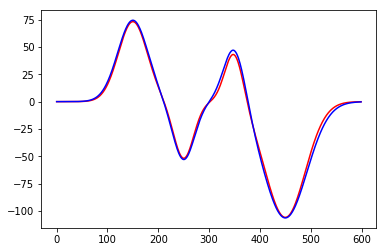

In [11]:
plot(sum(fieldS[20,:,:],axis=1),'-r')
plot(sum(zz[20,:,:],axis=1),'-b')

# Background slope

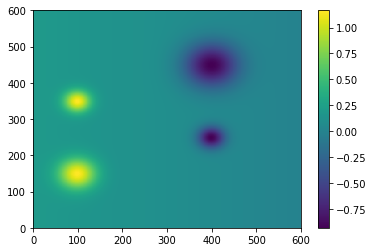

In [12]:
zz1=ones([600,600])*linspace(0.2,0,600)
zzz=moveGaussian(600,70,array([[x,x*0+150] for x in linspace(100,400,40)]),40)+\
    moveGaussian(600,50,array([[x,x*0+350] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,50,array([[500-x,x*0+250] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,100,array([[500-x,x*0+450] for x in linspace(100,400,40)]),40)
zz=zz1+zzz    

lat=linspace(0,10,600)
lon=linspace(0,10,600)
pcolormesh(zz[0,:,:])
colorbar()

In [13]:
eddytdp=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,0.4,0.1,0.1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,-0.4,-0.1,-0.1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

 0% [=======================================>]100% Time Elapsed: 38 s  Number of contours analysed: 43 
 0% [=======================================>]100% Time Elapsed: 39 s  Number of contours analysed: 80 


In [14]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)

In [15]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
fieldSn=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
fieldS=fieldSp+fieldSn

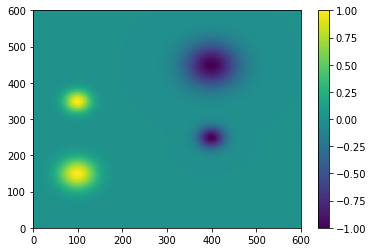

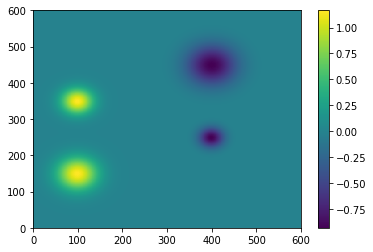

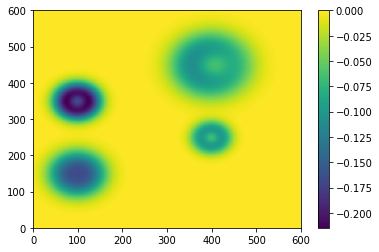

In [16]:
pcolormesh(zz[0,:,:]-zz1)
colorbar()
show()
pcolormesh(fieldS[0,:,:])
colorbar()
show()
pcolormesh(zz[0,:,:]-zz1-fieldS[0,:,:])
colorbar()

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zzz[ii,:,:],axis=1),sum(fieldS[ii,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zzz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zzz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(fieldS[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    line4a.set_data([], [])
    line4b.set_data([], [])
    text4.set_text('')
    return quad1,quad2,quad3,line4a,line4b,text4
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zzz[iter,:,:].ravel())
    quad3.set_array(zzz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    line4b.set_data(lat,sum(fieldS[iter,:,:],axis=1))
    text4.set_text(r'r^2 = %.2f' % rtext[iter])
    return quad1,quad2,quad3,line4a,line4b
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

# Simple Sinusoidal Background

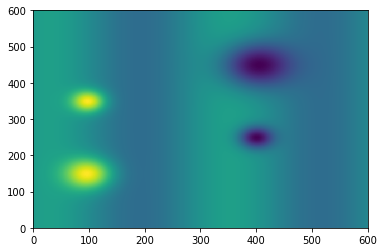

In [18]:
zz1=ones([600,600])*0.2*sin(linspace(1,4*pi,600))
zzz=moveGaussian(600,70,array([[x,x*0+150] for x in linspace(100,400,40)]),40)+\
    moveGaussian(600,50,array([[x,x*0+350] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,50,array([[500-x,x*0+250] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,100,array([[500-x,x*0+450] for x in linspace(100,400,40)]),40)
zz=zz1+zzz
    
lat=linspace(0,10,600)
lon=linspace(0,10,600)
pcolormesh(zz[0,:,:])

In [19]:
eddytdp=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,0.5,0.3,0.1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyzt(zz[:,:,:],lon,lat,0,40,1,-0.5,-0.3,-0.1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

 0% [=======================================>]100% Time Elapsed: 23 s  Number of contours analysed: 80 
 0% [=======================================>]100% Time Elapsed: 28 s  Number of contours analysed: 80 


In [20]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
fieldSn=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
fieldS=fieldSp+fieldSn

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zzz[ii,:,:],axis=1),sum(fieldS[ii,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zzz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zzz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(fieldS[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    line4a.set_data([], [])
    line4b.set_data([], [])
    text4.set_text('')
    return quad1,quad2,quad3,line4a,line4b,text4
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zzz[iter,:,:].ravel())
    quad3.set_array(zzz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    line4b.set_data(lat,sum(fieldS[iter,:,:],axis=1))
    text4.set_text(r'r^2 = %.2f' % rtext[iter])
    return quad1,quad2,quad3,line4a,line4b
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2